#### For Testing the model, skip the training part. Here is [Testing.](#Testing-the-model)

### Import Libraries

In [1]:
import numpy as np
import os
import glob
import cv2
import shutil
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import model_from_json
from matplotlib import pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from keras import utils
%matplotlib inline

Using TensorFlow backend.


### Load the haarcascade classifier

In [2]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 

We have defined the __loadImages__ function to load the dataset and applied the Haarcascade on it. It will help in extracting the face from the images, i.e. to remove background noise. At last, I have flatten the image and stored in a list __filenames__.

### Haar Cascade Parameters Selection

1. __minNeighbors = 8__: Parameter specifying how many neighbors each candidate rectangle should have to retain it.
This parameter will affect the quality of the detected faces. Higher value results in less detections but with higher quality. Since our dataset has only 1 face per image, hence less detections with higher accuracy is more favourable. 


2. __scaleFactor = 1.01__: Parameter specifying how much the image size is reduced at each image scale.
This parameter used to specify the setp size (5% here) in multi-scale representation of an image such that the face detection can be scale-invariant. Lower the step size, slower the detction but more is the chance of getting a matching box suitable for model.


3. __minSize__ and __maxSize__ parameters are not tuned as they are not very useful in our case of constrained face data.

### Haar Cascade Drawback
It expects the face to be fully contained in the image and even if a small portion of the face is  missing, it fails out. And I don't want to add noisy data so I have removed the images that are not processed by Haar Cascade. But it is unaffordable to loose any image in such a small dataset, hence to consider all the images, I have used another face detection approach by Dlib.

In [3]:
def loadImages():
    
    imgs_array = []
    filenames=[]
    for img_file in glob.glob(os.path.join('./BioID-FaceDatabase-V1.2/', "*.pgm")):
        try:
            img = cv2.imread(img_file,0)
            (x,y,w,h) = face_detector.detectMultiScale(img, 1.01, minNeighbors=8)[0]
            face = img[y:y+h, x:x+w]
            face = cv2.resize(face,(100,100))
            imgs_array.append(face.flatten())
            filenames.append(img_file)
        except:
            print(img_file)
    return imgs_array, filenames

In [4]:
data, filenames = loadImages()
data = np.array(data)

./BioID-FaceDatabase-V1.2/BioID_1174.pgm
./BioID-FaceDatabase-V1.2/BioID_0054.pgm
./BioID-FaceDatabase-V1.2/BioID_0053.pgm
./BioID-FaceDatabase-V1.2/BioID_1473.pgm
./BioID-FaceDatabase-V1.2/BioID_1477.pgm
./BioID-FaceDatabase-V1.2/BioID_0146.pgm
./BioID-FaceDatabase-V1.2/BioID_1476.pgm
./BioID-FaceDatabase-V1.2/BioID_1474.pgm
./BioID-FaceDatabase-V1.2/BioID_1475.pgm
./BioID-FaceDatabase-V1.2/BioID_1449.pgm
./BioID-FaceDatabase-V1.2/BioID_1450.pgm
./BioID-FaceDatabase-V1.2/BioID_1478.pgm
./BioID-FaceDatabase-V1.2/BioID_0376.pgm
./BioID-FaceDatabase-V1.2/BioID_1069.pgm
./BioID-FaceDatabase-V1.2/BioID_1445.pgm
./BioID-FaceDatabase-V1.2/BioID_1447.pgm
./BioID-FaceDatabase-V1.2/BioID_1484.pgm
./BioID-FaceDatabase-V1.2/BioID_0177.pgm
./BioID-FaceDatabase-V1.2/BioID_0176.pgm
./BioID-FaceDatabase-V1.2/BioID_1485.pgm
./BioID-FaceDatabase-V1.2/BioID_1446.pgm
./BioID-FaceDatabase-V1.2/BioID_1442.pgm
./BioID-FaceDatabase-V1.2/BioID_1481.pgm
./BioID-FaceDatabase-V1.2/BioID_1482.pgm
./BioID-FaceData

#### Check the shape of the data

In [5]:
data.shape

(1494, 10000)

## KMeans Clustering

As we know that the dataset which we collected is not labled so with the help of Kmeans clustering I have made the clusters which will be helpful in labling the data. As there are 23 persons, so 23 clusters are considered.

In [6]:
kmeans = KMeans(n_clusters=23)
kmeans = kmeans.fit(data)
labels = kmeans.predict(data)

Saving the images as per the labels suggested by clustering over HaarCascade processed images.

In [7]:
for i,each in enumerate(labels):
    each = str(each)
    if not os.path.exists('result/'+each):
        os.makedirs('result/'+each)
    shutil.copy(filenames[i],'result/'+each+'/')

In [8]:
#one-hot encoding suitable for SoftMax
one_hot_labels = utils.to_categorical(labels,23)

In [9]:
#Preprocessing the image data
data = data.reshape(-1,100,100,1)
data = data/255.0
data = data - data.mean()

In [10]:
data.shape,one_hot_labels.shape

((1494, 100, 100, 1), (1494, 23))

In [11]:
X_train,X_test,y_train,y_test = train_test_split(data,one_hot_labels,test_size=0.2)
#since data is less, test split is reduced

In [12]:
X_train.shape,y_train.shape,X_test.shape

((1195, 100, 100, 1), (1195, 23), (299, 100, 100, 1))

In [13]:
def createmodel():
    model = Sequential()
    model.add(Convolution2D(32, (3, 3) , init='he_normal',activation='relu',input_shape=(100,100,1)))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="tf"))

    model.add(Convolution2D(64,( 3, 3),activation='relu', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="tf"))

    model.add(Convolution2D(64, (3, 3),activation='relu', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2),dim_ordering="tf"))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(100,activation='relu'))
    
    model.add(Dense(23,activation='softmax'))

    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [14]:
model = createmodel()
history=model.fit(X_train, y_train, batch_size=8, epochs=20,
               verbose=1, validation_data=(X_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(100, 100,..., kernel_initializer="he_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_last")`
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal")`
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to

Train on 1195 samples, validate on 299 samples
Epoch 1/20
1195/1195 [==============================] - 10s 8ms/step - loss: 1.0718 - acc: 0.6895 - val_loss: 0.3631 - val_acc: 0.8896
Epoch 2/20
1195/1195 [==============================] - 9s 8ms/step - loss: 0.2486 - acc: 0.9230 - val_loss: 0.2991 - val_acc: 0.8763
Epoch 3/20
1195/1195 [==============================] - 10s 9ms/step - loss: 0.1744 - acc: 0.9423 - val_loss: 0.2357 - val_acc: 0.9298
Epoch 4/20
1195/1195 [==============================] - 9s 8ms/step - loss: 0.1449 - acc: 0.9506 - val_loss: 0.2968 - val_acc: 0.9064
Epoch 5/20
1195/1195 [==============================] - 11s 9ms/step - loss: 0.1035 - acc: 0.9690 - val_loss: 0.2904 - val_acc: 0.9130
Epoch 6/20
1195/1195 [==============================] - 12s 10ms/step - loss: 0.0859 - acc: 0.9766 - val_loss: 0.2619 - val_acc: 0.9331
Epoch 7/20
1195/1195 [==============================] - 11s 10ms/step - loss: 0.0587 - acc: 0.9816 - val_loss: 0.2356 - val_acc: 0.9365
Epoch 8/

## Saving the model

In [15]:
model_json = model.to_json()
with open("haar_softmax_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("haar_softmax_model.h5")
print("Saved model to disk")

Saved model to disk


####  General Utility for getting output of any layer of the model

In [16]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

In [17]:
# testing a image, second img here
x = functor([[data[2]],0]) #learning phase: 0(test)

In [18]:
len(x)

10

In [19]:
for i in range(10):
    print(x[i].shape)

(1, 98, 98, 32)
(1, 49, 49, 32)
(1, 47, 47, 64)
(1, 23, 23, 64)
(1, 21, 21, 64)
(1, 10, 10, 64)
(1, 10, 10, 64)
(1, 6400)
(1, 100)
(1, 23)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


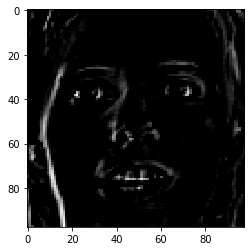

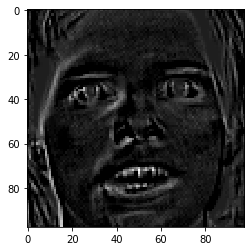

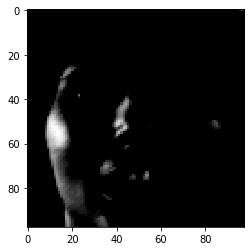

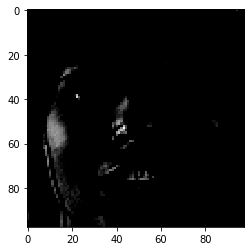

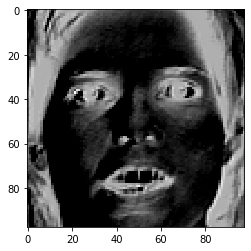

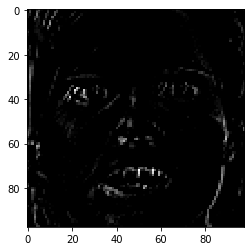

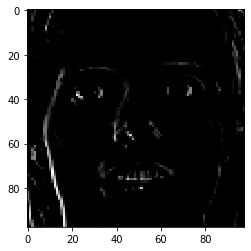

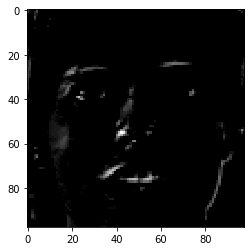

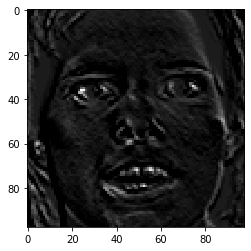

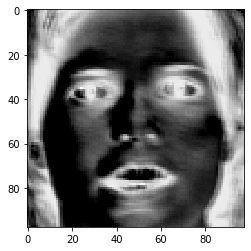

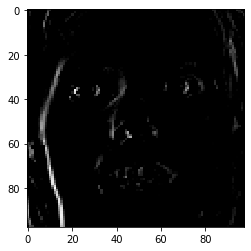

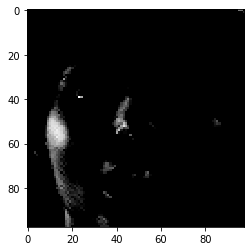

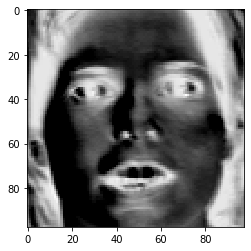

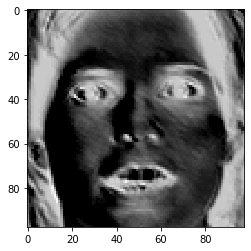

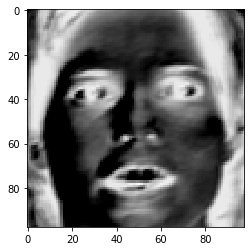

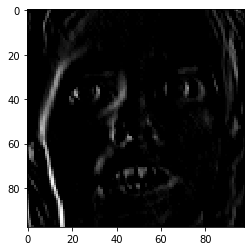

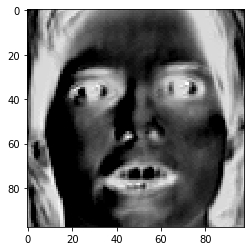

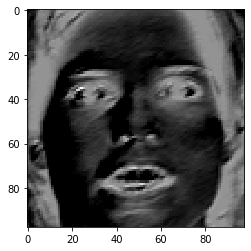

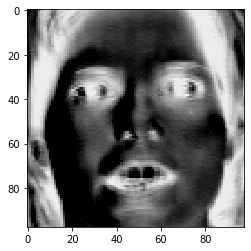

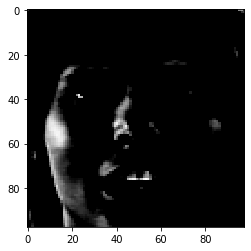

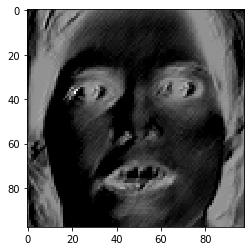

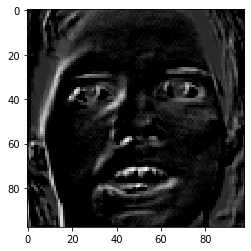

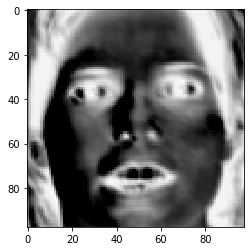

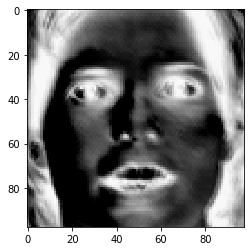

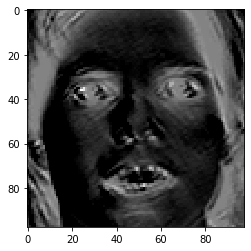

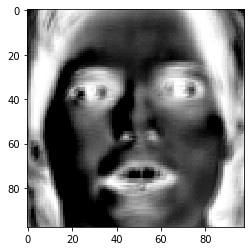

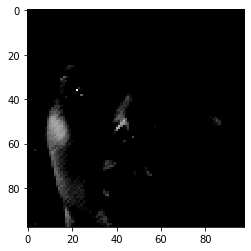

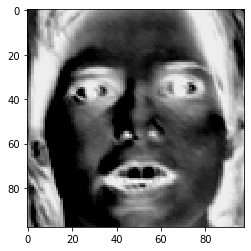

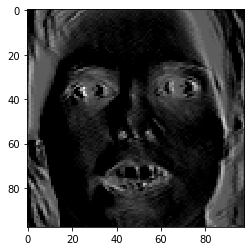

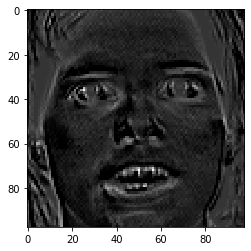

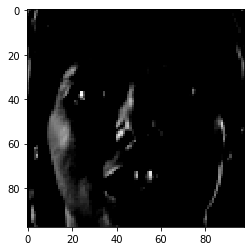

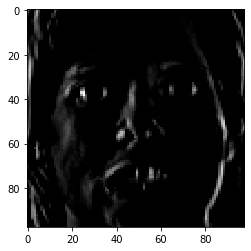

In [20]:
for i in range(32):
    plt.figure()
    plt.imshow(x[0][0,:,:,i],cmap='gray') # checking output from all kernels of 1st layer

# Testing the model

In [21]:
import numpy as np
import os
import glob
import cv2
import shutil
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import model_from_json
from matplotlib import pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from keras import utils
%matplotlib inline

In [22]:
# loading the model
json_file = open('haar_softmax_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("haar_softmax_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [23]:
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

In [24]:
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') 

In [25]:
def show(im):
    plt.figure()
    plt.imshow(im[:,:,0],cmap='gray')

In [26]:
def load_img(img):
    img = cv2.imread(img,0)
    (x,y,w,h) = face_detector.detectMultiScale(img, 1.05, 8)[0] # scaleFactor = 5% to increase infernce time
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face,(100,100))
    return face.reshape(100,100,1)

In [27]:
def similarity(im1,im2):
    show(im1)
    show(im2)
    f1 = functor([[im1],0])[7][0] #flatten layer output
    f2 = functor([[im2],0])[7][0]
    return cosine_similarity([f1],[f2])

In [28]:
def compare(im1_path, im2_path):
    im1 = load_img(im1_path)
    im2 =load_img(im2_path)
    return similarity(im1,im2)

array([[0.98180664]], dtype=float32)

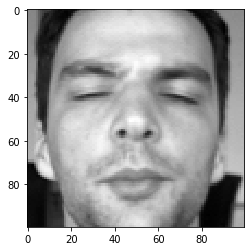

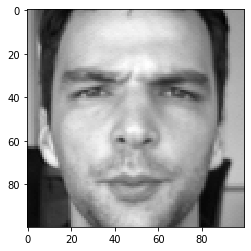

In [29]:
compare('BioID-FaceDatabase-V1.2/BioID_0003.pgm','BioID-FaceDatabase-V1.2/BioID_0001.pgm')

array([[0.08613291]], dtype=float32)

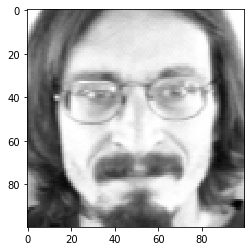

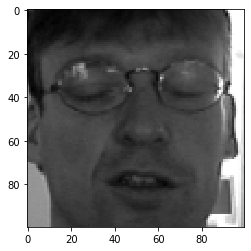

In [30]:
similarity(X_test[10],X_test[20])